## Contents
- [Data Importing](#Data-Importing)
- [Classification metrics](#Classification-metrics)
- [Vectorizer Selection via GridSeachCV](#Vectorizer-Selection-via-GridSeachCV)
- [MultinomialNB and Hyperparameter tuning](#MultinomialNB-and-Hyperparameter-tuning)
- [Logistic Regression Modelling and Hyperparameter tuning](#Logistic-Regression-Modelling-and-Hyperparameter-tuning)
- [Analysis on top few features by logreg and MultinomialNB](#Analysis-on-top-few-features-by-logreg-and-MultinomialNB)
- [Random Forest Classifier](#Random-Forest-Classifier)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)

In [324]:
import pandas as pd
import requests
import string
string.punctuation
import re
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import contractions

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, \
    plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from transformers import pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize   
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.dates as mdate
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec


from sklearn.model_selection import(
    cross_val_score,
    train_test_split,
    GridSearchCV
)

from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
from datetime import timezone
import datetime

pd.set_option('display.max_colwidth', None)

## Data importing

In [2]:
df = pd.read_csv('../Data/df.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)

Check for Null

In [3]:
df.isnull().sum()

author                   0
subreddit                0
selftext                 0
title                    0
created_utc              0
datetime                 0
link_flair_css_class     0
alltext                  0
length_text              0
wrdcount_text            0
month                    0
day                      0
clean_text               1
ttl_post                 0
user_contribute_where    0
stem_clean_text          1
lemmi_clean_text         1
dtype: int64

In [4]:
df.dropna(inplace = True)

###  Model Prep: Create `X` and `y` variables

Our features will be:
- `subreddit`
- `stem_clean_text`
- `lemmi_clean_text`

For our baseline modelling will be using lemmi_clean_text

Our target will be `subreddit`

In [5]:
X = df['lemmi_clean_text']
y = df['subreddit']

### Train/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Classification Metrics

Possible classification metrics that can be used how well my model perform are *Accuracy, Misclassification Rate, Sensitivity (True Positive Rate), Specificity (True Negative Rate), Precision (Positive Predictive Value), F1 Score and ROC AUC*.

For this project I will be mainly using *Accuracy* accompanied with confusion matrix to determine effectiveness of my models

For further evaluations, I will be using Specificity to choose the best model that helps gauge on how best to minimize this in order to reduce missing out identifying users potentionally having PTSD.

I will also use ROC to gave a gauge the degree of overlap between the words in post from the two subreddits. 

### Baseline Accuracy Check

In [7]:
print(f'Total post: {len(df)}')
df['subreddit'].value_counts(normalize= True)


Total post: 20228


1    0.500395
0    0.499605
Name: subreddit, dtype: float64

With 10000 post added into each class, the classes are very well balanced from both sides 

Also, from the above, we can see the ***baseline accuracy*** is at 50.1%. 
If nothing ws done for the classification model, and just to assign every post to the PTSD class, i would classify 50.1% of the post correctly. 

Therefore, any classification model designed for this data must have an accuracy higher than the ***baseline accuracy*** of 50.1%

## Vectorizer Selection via GridSeachCV

Consider two NLP vectorizers and iterate over parameters below with Logistic regression model first.
- *Count Vectorizer*
- *TF-IDF Vectorizer*

In [407]:
# create stop word list 
stopwordlist = nltk.corpus.stopwords.words('english')

# to input in subreddit headers so that we can exclude it for model
headers = ['ptsd', 'anxiety',"cptsd", 'trauma','traumatized','traumas',"posttraumatic",'stress','disorder',"traumatic", 'www', 'https', 'mentalgrenade', 'com']
for head in headers:
    stopwordlist.append(head)



In [19]:
# Creating Pipeline with:
# Estimator: LogisticRegression (both)
# Transformer: CountVectorizer - pipe1, TfidfVectorizer - pipe2

pipe1 = Pipeline([('cvec1', CountVectorizer(stop_words= stopwordlist)),
                  ('logreg1', LogisticRegression())
                 ])

pipe2 = Pipeline([('tfvec2', TfidfVectorizer(stop_words= stopwordlist)),
                  ('logreg2', LogisticRegression())
                 ])

In [20]:
# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe1_params = {'cvec1__max_features': [1000],
                'cvec1__min_df': [0.02],
                'cvec1__max_df': [0.7],
                'cvec1__ngram_range': [(1,1), (1,2)],
                'logreg1__max_iter': [1000]
               }

pipe2_params = {'tfvec2__max_features': [1000],
                'tfvec2__min_df': [0.02],
                'tfvec2__max_df': [0.7],
                'tfvec2__ngram_range': [(1,1), (1,2)],
                'logreg2__max_iter': [1000]
               }

In [21]:
# Creating two separate GridSearchCV objects for:
# CountVectorizer and TfidfVectorizer

gs_pipe1 = GridSearchCV(pipe1, param_grid=pipe1_params, cv=5)

gs_pipe2 = GridSearchCV(pipe2, param_grid=pipe2_params, cv=5)

In [22]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec1',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
 

In [23]:
# Fitting GridSearchCV with TfidfVectorizer transformer on X_train and y_train.

gs_pipe2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec2',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',


In [24]:
# Best combination of hyperparameters suggested by GridSearchCV for CountVectorizer transformer.

gs_pipe1.best_params_

{'cvec1__max_df': 0.7,
 'cvec1__max_features': 1000,
 'cvec1__min_df': 0.02,
 'cvec1__ngram_range': (1, 1),
 'logreg1__max_iter': 1000}

In [25]:
# Best combination of hyperparameters suggested by GridSearchCV for TfidfVectorizer transformer.

gs_pipe2.best_params_

{'logreg2__max_iter': 1000,
 'tfvec2__max_df': 0.7,
 'tfvec2__max_features': 1000,
 'tfvec2__min_df': 0.02,
 'tfvec2__ngram_range': (1, 1)}

In [26]:
# Summary scores of CountVectorizer and LogisticRegression.

print("CountVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe1.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe1.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe1.score(X_test, y_test), 3)}")

CountVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.81

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.837
Testing corpus accuracy = 0.81


In [27]:
# Summary scores of TfidfVectorizer and LogisticRegression.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe2.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe2.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe2.score(X_test, y_test), 3)}")

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.816

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.837
Testing corpus accuracy = 0.816


In [28]:
# Creacting a summary dataframe.

summary_df = pd.DataFrame(columns=['transformer_estimator', 
                                   'GS_best_params', 
                                   'GS_best_score', 
                                   'train_accuracy', 
                                   'test_accuracy'
                                  ])

In [29]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[1] = ['CountVec, LogReg',
                     str(gs_pipe1.best_params_),
                     round(gs_pipe1.best_score_, 3),
                     round(gs_pipe1.score(X_train, y_train), 3),
                     round(gs_pipe1.score(X_test, y_test), 3)
                    ]

summary_df.loc[2] = ['TfidfVec, LogReg',
                     str(gs_pipe2.best_params_),
                     round(gs_pipe2.best_score_, 3),
                     round(gs_pipe2.score(X_train, y_train), 3),
                     round(gs_pipe2.score(X_test, y_test), 3)
                    ]

In [30]:
summary_df

,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,"CountVec, LogReg","{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.810,0.837,0.810
2,"TfidfVec, LogReg","{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.816,0.837,0.816


From the summary table, we can infer that the best combination of transformer hyperparameters to be 
- *max_features* = 500
- *min_df* = 0.05 
- *max_df* = 0.8 
- ngram_range=(1,2)	- for *tfidfVectorizer*

Judging solely on the accuracy scores, using **CountVectorizer** has very good accuracy on the training but did poorly on the testing corpus. This implies that this model is **overfitting on the training corpus**. 

On the other, using **TfidfVectorizer** transformer has better accuracy fir GSCV best score, and lesser delta between the train and test accuracy scores, suggesting that the **model may not be as overfitted than *CountVectorizer***

Therefore, I will use *TfidfVectorizer* for further classification model.



## Hyper-parameter tuning

### MultinomialNB Classifier

There are 3 common types of Naive Bayes models: *Bernoulli Naive Bayes*, *Multinomial Naive Bayes*, and *Gaussian Naive Bayes*.

- [Bernoulli Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB): when we have 0/1 variables.
- [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB): when our variables are positive integers.
- [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB): when our features are Normally distributed.

We will be using ***MultinomialNB*** as it consideres a feature vector with all the individual words in a all post where a given term represent the number of times it appears. 

In [31]:
# create pipe3 for transformer: TfidfVectorizer and estimator using MultinomialNB

pipe3 = Pipeline([('tfvec', TfidfVectorizer(stop_words= stopwordlist)),
                  ('nb', MultinomialNB())
                 ])

In [32]:
# creating parameters for GridSearch SV using hyperparameters as shown below 
pipe3_params = {'tfvec__max_features': [3500,4500,5500],
                'tfvec__min_df': [0.001, 0.005, 0.01],
                'tfvec__max_df': [0.7,0.75,0.8],
                'tfvec__ngram_range': [(1,1)],
                'nb__alpha' : [1.0e-10]
}

In [33]:
# Creatingg GridSeachCV using pipeline: pipe3 and params_grid:  pipe3_params

gs_pipe3 = GridSearchCV(pipe3, param_grid=pipe3_params, cv=5)

In [34]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
 

In [35]:
# Get best parameters using MultinomialNB and TfidfVectorizer

gs_pipe3.best_params_

{'nb__alpha': 1e-10,
 'tfvec__max_df': 0.7,
 'tfvec__max_features': 3500,
 'tfvec__min_df': 0.001,
 'tfvec__ngram_range': (1, 1)}

In [36]:
# Summary scores of TfidfVectorizer and MultinomialNB.

print("TfidfVectorizer with MultinomialNB summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe3.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe3.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe3.score(X_test, y_test), 3)}")

TfidfVectorizer with MultinomialNB summary of accuracy scores:
GridSearchCV best accuracy = 0.831

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.856
Testing corpus accuracy = 0.832


In [37]:
# adding summary 

summary_df.loc[3] = ['TfidfVec, MultinomialNB',
                     str(gs_pipe3.best_params_),
                     round(gs_pipe3.best_score_, 3),
                     round(gs_pipe3.score(X_train, y_train), 3),
                     round(gs_pipe3.score(X_test, y_test), 3)
                    ]

In [38]:
summary_df

,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,"CountVec, LogReg","{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.810,0.837,0.810
2,"TfidfVec, LogReg","{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.816,0.837,0.816
3,"TfidfVec, MultinomialNB","{'nb__alpha': 1e-10, 'tfvec__max_df': 0.7, 'tfvec__max_features': 3500, 'tfvec__min_df': 0.001, 'tfvec__ngram_range': (1, 1)}",0.831,0.856,0.832


From the above table, we can see that Multinomial has overall better scores than the Log Reg. The model is relatively overfitted as well. Lets breakdown to see what are the most impactful words that distinguishes between users in r/PTSD and those who arent. 

### Logistic Regression Modelling

In [39]:
# Creating Pipeline with:
# Estimator: LogisticRegression (both)
# Transformer: CountVectorizer - pipe1, TfidfVectorizer - pipe2

pipe4 = Pipeline([('tfvec4', TfidfVectorizer(stop_words= stopwordlist)),
                  ('logreg4', LogisticRegression())
                 ])

In [40]:
# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe4_params = {'tfvec4__max_features': [200,500,1000],
                'tfvec4__min_df': [0.02, 0.05],
                'tfvec4__max_df': [0.5,0.6,0.7],
                'tfvec4__ngram_range': [(1,1), (1,2)],
                'logreg4__max_iter': [1000]
               }

In [41]:
# Creating two separate GridSearchCV objects for:
# TfidfVectorizer and Logistic Regression with Hyper-parameter tuning

gs_pipe4 = GridSearchCV(pipe4, param_grid=pipe4_params, cv=5)

In [42]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec4',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',


In [43]:
# Best combination of hyperparameters suggested by GridSearchCV for TfidfVectorizer transformer.

gs_pipe4.best_params_

{'logreg4__max_iter': 1000,
 'tfvec4__max_df': 0.5,
 'tfvec4__max_features': 1000,
 'tfvec4__min_df': 0.02,
 'tfvec4__ngram_range': (1, 2)}

In [44]:
# Summary scores of CountVectorizer and LogisticRegression.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe4.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe4.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe4.score(X_test, y_test), 3)}")

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.817

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.838
Testing corpus accuracy = 0.814


In [45]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[4] = ['TfidfVec, LogisticRegression',
                     str(gs_pipe4.best_params_),
                     round(gs_pipe4.best_score_, 3),
                     round(gs_pipe4.score(X_train, y_train), 3),
                     round(gs_pipe4.score(X_test, y_test), 3)
                    ]

In [46]:
summary_df

,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,"CountVec, LogReg","{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.810,0.837,0.810
2,"TfidfVec, LogReg","{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.816,0.837,0.816
3,"TfidfVec, MultinomialNB","{'nb__alpha': 1e-10, 'tfvec__max_df': 0.7, 'tfvec__max_features': 3500, 'tfvec__min_df': 0.001, 'tfvec__ngram_range': (1, 1)}",0.831,0.856,0.832
4,"TfidfVec, LogisticRegression","{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.5, 'tfvec4__max_features': 1000, 'tfvec4__min_df': 0.02, 'tfvec4__ngram_range': (1, 2)}",0.817,0.838,0.814


The MultinomialNB has the highest scores, with slight overfit to test accuracy scores. 
However, I did notice that the Logistic Regression after hyperparameter tuning, it was able to pick up ngrams with range of 2 as a best parameter. 

### Random Forest Classifier

In [244]:
# Creating Pipeline with:
# Estimator: Random Forest Classifier
# Transformer: TfidfVectorizer - pipe5

pipe5 = Pipeline([('tfvec5', TfidfVectorizer(stop_words= stopwordlist)),
                  ('RanForest', RandomForestClassifier())
                 ])

In [245]:
# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe5_params = {'tfvec5__max_features': [200,500],
                'tfvec5__min_df': [0.01, 0.02],
                'tfvec5__max_df': [0.6,0.7],
                'tfvec5__ngram_range': [(1,1), (1,2)],
                'RanForest__n_estimators': [100, 150],
                'RanForest__max_depth': [3,5],
                'RanForest__max_features': ['sqrt','log2', 0.5]
               }

In [246]:
# Creating two separate GridSearchCV objects for:
# TfidfVectorizer and RandomForestClassifier with Hyper-parameter tuning

gs_pipe5 = GridSearchCV(pipe5, param_grid=pipe5_params, cv=5)

In [247]:
# Fitting GridSearchCV with TfidfVectorizer transformer on X_train and y_train.

gs_pipe5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec5',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',


In [248]:
# Best combination of hyperparameters suggested by GridSearchCV for TfidfVectorizer transformer.

gs_pipe5.best_params_

{'RanForest__max_depth': 5,
 'RanForest__max_features': 'sqrt',
 'RanForest__n_estimators': 150,
 'tfvec5__max_df': 0.7,
 'tfvec5__max_features': 500,
 'tfvec5__min_df': 0.01,
 'tfvec5__ngram_range': (1, 2)}

In [249]:
# Summary scores of TfidfVectorizer and RandomForestClassifier.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe5.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe5.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe5.score(X_test, y_test), 3)}")

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.761

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.767
Testing corpus accuracy = 0.746


In [250]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[5] = ['TfidfVec, RandomForest',
                     str(gs_pipe5.best_params_),
                     round(gs_pipe5.best_score_, 3),
                     round(gs_pipe5.score(X_train, y_train), 3),
                     round(gs_pipe5.score(X_test, y_test), 3)
                    ]

In [251]:
summary_df

,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,"CountVec, LogReg","{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.810,0.837,0.810
2,"TfidfVec, LogReg","{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.816,0.837,0.816
3,"TfidfVec, MultinomialNB","{'nb__alpha': 1e-10, 'tfvec__max_df': 0.7, 'tfvec__max_features': 3500, 'tfvec__min_df': 0.001, 'tfvec__ngram_range': (1, 1)}",0.831,0.856,0.832
4,"TfidfVec, LogisticRegression","{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.5, 'tfvec4__max_features': 1000, 'tfvec4__min_df': 0.02, 'tfvec4__ngram_range': (1, 2)}",0.817,0.838,0.814
6,"TfidfVec, MultinomialNB_withStopwordAdded","{'nb__alpha': 1e-10, 'tfvec__max_df': 0.7, 'tfvec__max_features': 3500, 'tfvec__min_df': 0.001, 'tfvec__ngram_range': (1, 1)}",0.829,0.854,0.832
5,"TfidfVec, RandomForest","{'RanForest__max_depth': 5, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 150, 'tfvec5__max_df': 0.7, 'tfvec5__max_features': 500, 'tfvec5__min_df': 0.01, 'tfvec5__ngram_range': (1, 2)}",0.761,0.767,0.746


## Error Analysis

### Analysis on top few features

Comparison between Logistic Regression and MultinomialNB

Features were selected by retrieving the coefficients from the Logistic regression and the relative difference of log probability from multinomialNB model.

In [252]:
df_logreg = pd.DataFrame([[x,y] for x,y in zip(gs_pipe2.best_estimator_[0].get_feature_names_out(), (gs_pipe2.best_estimator_[1].coef_).tolist()[0])])
df_logreg.rename(columns= {0: 'Features', 1: 'Coefficients'}, inplace = True)
df_logreg.sort_values(by = 'Coefficients', ascending = False).head(15)

,Features,Coefficients
198,flashback,8.892989
368,nightmare,6.778599
2,abuse,5.570160
558,triggered,5.204683
4,abuser,5.153748
237,happened,4.852930
126,diagnosed,4.776442
557,trigger,4.558818
3,abused,4.138784
5,abusive,4.083983


In [253]:
delta = gs_pipe3.best_estimator_[1].feature_log_prob_[1, :] - gs_pipe3.best_estimator_[1].feature_log_prob_[0, :]

df_multinomial = pd.DataFrame([[x,y] for x,y in zip(gs_pipe3.best_estimator_[0].get_feature_names_out(),(delta))])
df_multinomial.rename(columns= {0: 'Features', 1: 'log_prob_diff'}, inplace = True)
df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).head(15)

,Features,log_prob_diff
2412,raped,26.453170
2411,rape,26.384407
2286,prazosin,26.101458
1168,firework,25.743222
718,csa,25.327090
455,cannabis,24.971071
3006,survey,24.845533
2206,perpetrator,24.819069
1511,hypervigilant,24.598624
2894,stalked,24.334230


**Comments on top few features**
- For logistic regression model, the top few features like 'flashbacks', 'nightmares', 'triggers' can serve as ***true symptoms of users suffering from PTSD***. Based on ([*source*](https://www.psychologytoday.com/us/conditions/post-traumatic-stress-disorder)), patients suffering from PTSD then to have those stated features. 
- Although it contains some words like 'abuse' that might describe ***causes of PTSD***, I believe when looking at the top few features from MultinomialNB, I can find more words that describes the ***causes AND triggers of PTSD*** more like 'rape', 'firework', 'assault', 'csa' which stands for childhood sexual abuse, 'repressed', 'stalked'.

- Overall by far, aligned with the accuracy score, I would conclude that MultinomialNB is more superior in getting defining words that may classifiy people with PTSD more. 

In [254]:
df.loc[df['lemmi_clean_text'].str.contains('firework'), 'lemmi_clean_text'][0:3]

35                                                                                                                                                                                                                                    anyone else feel sound hit body awful hate freaking firework
47      last night bad asking neighbor heard anything could sworn heard gun shot maybe firework nothing ordinary live country maybe people hunting bed started shaking though kept seeing dark people figure triggered feel drained crap sleep getting day like nothing happened want control vent
1646                                                                                                                                                                                                     extremely scared firework past abuse tonight firework show distract firework show tonight
Name: lemmi_clean_text, dtype: object

In [255]:
df[df['lemmi_clean_text'].str.contains('firework')].groupby('month').count()[['author']]

,author
month,
1,7
2,3
5,1
6,7
7,33
8,5
9,4
10,3
11,5


***Firework Identified***

Found Fireworks seem to be interesting, upon investigating main dataset, the word mainly coming from the text and the title as well, explaining they have triggers likely due to firework loud noises. 

The fact that it was highlighted as a main feature, suggest that it might be severe more with users from r/PTSD. True enough, based on ([*source*](https://www.insider.com/how-fireworks-affect-you-from-increased-anxiety-and-memory-problems-2020-7#:~:text=Repetitive%20fireworks%20launched%20at%20night,can%20weaken%20your%20immune%20system.)), people with past trauma related to sound are impacted significantly worse by loud explosion of fireworks, causing reminiscent of threat and may have activated the brain's threat detector. 

Linking back to the EDA on post, we did see spikes on July 2021.Based on ([*source*](https://wgntv.com/news/fireworks-retailer-warns-of-july-4-shortage-here-are-the-states-where-its-legal-to-stock-up/)), there is seasonal fireworks on every 4th of July across many states in the US. Although we cant assume most users from the subreddits are from US, but it is room for exploration, to deep dive into the location and firework activities. 



### What is the sensitivity of all pipelines 

In [256]:
# What is the test sensitivity of our model?
# By hand
list_of_gs = [gs_pipe1, gs_pipe2, gs_pipe3, gs_pipe4]


sensitivity_df = []
for gs in list_of_gs:
    preds = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();
    sensitivity_df.append(tp / (tp + fn))


sensitivity_df= pd.DataFrame(sensitivity_df)

In [257]:
summary_sensitivity = pd.merge(summary_df.reset_index(), sensitivity_df, left_index=True, right_index=True).drop(columns = 'index').rename(columns = {0:'Sensitivity'})
summary_sensitivity.sort_values(by = 'Sensitivity', ascending = False)

,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy,Sensitivity
2,"TfidfVec, MultinomialNB","{'nb__alpha': 1e-10, 'tfvec__max_df': 0.7, 'tfvec__max_features': 3500, 'tfvec__min_df': 0.001, 'tfvec__ngram_range': (1, 1)}",0.831,0.856,0.832,0.846306
1,"TfidfVec, LogReg","{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.816,0.837,0.816,0.789411
3,"TfidfVec, LogisticRegression","{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.5, 'tfvec4__max_features': 1000, 'tfvec4__min_df': 0.02, 'tfvec4__ngram_range': (1, 2)}",0.817,0.838,0.814,0.786250
0,"CountVec, LogReg","{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.810,0.837,0.810,0.770842


Clearly, we will choose MultinomialNB as our production model as it has relative higher accuracy scores, with minimal overfit and very high sensivity as compared to the rest of the models 

### Confusion matrix

We will use only MultinomialNB with the best params attained above for further error analysis 

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


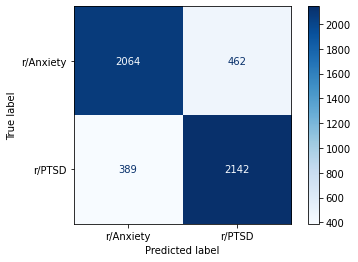

In [258]:
# Generate predictions.
preds = gs_pipe3.predict(X_test)

# Generate confusion matrix.
# Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

confusion_matrix(y_test, # True values.
                 preds)  # Predicted values.

# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

# Plot Confusion matrix
plot_confusion_matrix(gs_pipe3, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['r/Anxiety', 'r/PTSD']);                 

In [260]:
# create a dataframe to contain the posts, actual reddit and predicted reddit
y_test_pred_df = pd.DataFrame()
y_test_pred_df['index'] = y_test.index
y_test_pred_df['y'] = y_test.values
y_test_pred_df['y_pred'] = preds
y_test_pred_df = y_test_pred_df.merge(df.reset_index(), on = 'index')

y_test_pred_df = y_test_pred_df[['index','y','y_pred','lemmi_clean_text','month']]

In [271]:
y_test_pred_df = y_test_pred_df[(y_test_pred_df['y_pred'] == 0) & (y_test_pred_df['y'] == 1)]
y_test_pred_df

,index,y,y_pred,lemmi_clean_text,month
12,1485,1,0,recently started training new job cashier bos keep getting shakey hand seem nervous time got fired last job bad episode broke panic attack week working know tell cannot help shakey hand seem nervous time anyone advice work job like symptom like job get right like dealing customer get good look shakey hand everything honestly cannot help people like say real stigma come mental illness anymore come stuff like really afraid tell going want hire properly advice help would really appreciated work,10
18,1176,1,0,hey guy wondering physical symptom experienced result experienced sexual raped couple month ago since weak fatigued moment low blood pressure high heart rate feel dizzy lightheaded shortness breath chest pain etc joint muscle hurting lower back felt like muscle cramp etc appointment today doctor terrified feel like many different thing could starting feel alone idk panic attack changed eating body wearing know hoping could get insight thank physical effect,7
44,1718,1,0,recently got official diagnosis know enough could use guidance anyone similar experience far aware classed disability protected equality act recently prescribed new medication primarily assist however workplace told able use medication work instead must go home sick take entire day work medication schedule controlled drug therefore putting alcohol drug policy work really know stand surely discrimination uk doctor prescribed medication negatively impact ability work yet allowed work yet follow advise going work feel may problem surely would quickly find getting disciplined fired due attendance assistance would greatly appreciated help work,2
47,457,1,0,soon sit counselor begin shake uncontrollably end appointment end shake uncontrollably therapy,3
53,7178,1,0,hopeless right cannot deal anymore much therapy feel like everything getting worse please tell success helped need right anyone success story,9
...,...,...,...,...,...
5017,8286,1,0,fix speech trip word broca area,7
5023,8546,1,0,unforgiving want sleep want alone want fix situation minneapolis sooo messed right nothing know riot doctor office closed burn tried order med cannot find doctor idk family keep dying natural cause otherwise tired need real job college chef qualified know ready go back sea unforgiving,7
5027,3459,1,0,hello everyone two week ago got new colleague work closely nice dude felt like timid anxious get go tried open nice relax around today asked anything could make comfortable felt like tense lot time wondering anything made uncomfortable opened bank robbery three year ago first time working bank since incident said treatment taking medication hard regardless wondering anything make easier tried ask anything want talk said want anyone change way life really worried saying something could cause insensitive sth never met anyone sth like advice new colleague suffers due experiencing violent bank robbery need advice,1
5045,1080,1,0,friend group family always difficult one always opting thing trigger one trigger driving highway even dinner friend sometimes want drive lately started getting super irritated invited thing know difficult one people either accommodate stay home venting feeling especially exhausted today almost tear text today trying hang tired difficult one,2


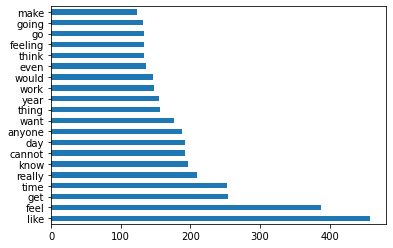

In [272]:
### Get common words from post above 

# instantiate column and target
X_ptsd = y_test_pred_df['lemmi_clean_text']
y_ptsd = y_test_pred_df['y']

# Instanstiate CountVectorizer()
cvec_1 = CountVectorizer()
cvec_1.fit(X_ptsd,y_ptsd)
X_ptsd = cvec_1.transform(X_ptsd)

# create dataframe for ptsd and anxiety
X_ptsd_df = pd.DataFrame(X_ptsd.todense(), 
                          columns=cvec_1.get_feature_names_out())

X_ptsd_df.sum().sort_values(ascending=False).head(20).plot(kind='barh');                          

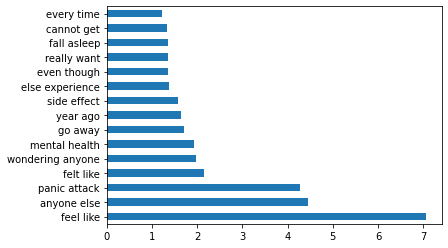

In [292]:
# instantiate column and target
X_ptsd_trigram = y_test_pred_df['lemmi_clean_text']
y_ptsd_trigram = y_test_pred_df['y']
# Instanstiate CountVectorizer()
tvec = TfidfVectorizer(ngram_range=(2,2))

tvec.fit(X_ptsd_trigram,y_ptsd_trigram)
X_ptsd_trigram = tvec.transform(X_ptsd_trigram)

# create dataframe for ptsd and ptsd
X_ptsd_trigram_df = pd.DataFrame(X_ptsd_trigram.todense(), 
                          columns=tvec.get_feature_names_out())

X_ptsd_trigram_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');     

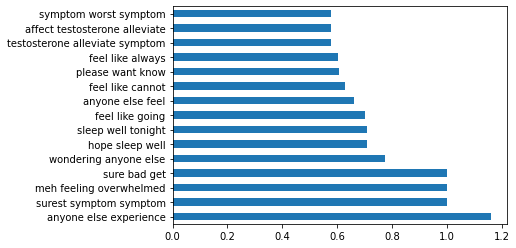

In [291]:
# instantiate column and target
X_ptsd_trigram = y_test_pred_df['lemmi_clean_text']
y_ptsd_trigram = y_test_pred_df['y']
# Instanstiate CountVectorizer()
tvec = TfidfVectorizer(ngram_range=(3,3))

tvec.fit(X_ptsd_trigram,y_ptsd_trigram)
X_ptsd_trigram = tvec.transform(X_ptsd_trigram)

# create dataframe for ptsd and ptsd
X_ptsd_trigram_df = pd.DataFrame(X_ptsd_trigram.todense(), 
                          columns=tvec.get_feature_names_out())

X_ptsd_trigram_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');     

In [320]:
gs_pipe3.predict_proba(X_test)

array([[0.73429515, 0.26570485],
       [0.4792489 , 0.5207511 ],
       [0.61715398, 0.38284602],
       ...,
       [0.12457304, 0.87542696],
       [0.70638845, 0.29361155],
       [0.65287911, 0.34712089]])

In [434]:
X_ptsd_trigram_df.head(15).corr()

In [322]:
print(get_predictions(gs_pipe3.predict_proba(X_test)[:,1], 0.5)[:10])

[0, 1, 0, 0, 0, 1, 0, 1, 1, 0]


In [321]:
print(get_predictions(gs_pipe3.predict_proba(X_test)[:,1], 0.3)[:10])

[0, 1, 1, 0, 1, 1, 0, 1, 1, 0]


In [387]:
def get_predictions(probabilities, threshold):
    return [0 if prob < threshold else 1 for prob in probabilities]

threshold_list = np.linspace(0.49,0.51,100)

class_prior_threshold = []
Accuracy = []
Sensitivity = []
for threshold in threshold_list:
    preds = get_predictions(gs_pipe3.predict_proba(X_test)[:,1], threshold)
    acc = accuracy_score(y_test, preds)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();
    sensi = tp / (tp + fn)
    class_prior_threshold.append(threshold)
    Accuracy.append(acc)
    Sensitivity.append(sensi)

We need to find possible thresholds that optimises both sensitivity and accuracy score. 

- Baseline score to beat is from gs_pipe3 (multinomialNB) = 0.8309
- Baseline sensitivity score: 0.846

In [392]:
class_prior_setter = pd.DataFrame([class_prior_threshold,Accuracy, Sensitivity]).T
class_prior_setter.columns = ['Threshold', 'Accuracy', 'Sensitivity']

preds = gs_pipe3.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();
sensitivity = tp / (tp + fn)

class_prior_setter[(class_prior_setter['Accuracy'] > gs_pipe3.best_score_) &\
     (class_prior_setter['Sensitivity'] > sensitivity)].sort_values(by = ['Sensitivity','Accuracy'],\
          ascending = [False,False]).head(5)


,Threshold,Accuracy,Sensitivity
31,0.496263,0.831125,0.851047
29,0.495859,0.830927,0.851047
30,0.496061,0.830927,0.851047
33,0.496667,0.831718,0.850652
32,0.496465,0.831323,0.850652


In [412]:
# create pipe3 for transformer: TfidfVectorizer and estimator using MultinomialNB

pipe6 = Pipeline([('tfvec', TfidfVectorizer(stop_words= stopwordlist)),
                  ('nb', MultinomialNB())
                 ])

creating parameters for GridSearch SV using hyperparameters as shown below 

pipe6_params = {'tfvec__max_features': [3500,4500,5500],
                'tfvec__min_df': [0.001, 0.005, 0.01],
                'tfvec__max_df': [0.7,0.75,0.8],
                'tfvec__ngram_range': [(1,1)],
                'nb__alpha' : [1.0e-10],
                'nb__class_prior': [None, [0.496263,(1-0.496263)]]

,subreddit,created_utc,length_text,wrdcount_text,month,ttl_post
subreddit,1.000000,-0.723959,0.131825,0.130242,0.650541,0.078063
created_utc,-0.723959,1.000000,-0.106937,-0.106030,-0.552357,-0.074091
length_text,0.131825,-0.106937,1.000000,0.997788,0.079697,-0.053988
wrdcount_text,0.130242,-0.106030,0.997788,1.000000,0.078750,-0.052331
month,0.650541,-0.552357,0.079697,0.078750,1.000000,0.055585
ttl_post,0.078063,-0.074091,-0.053988,-0.052331,0.055585,1.000000


In [423]:
# creating parameters for GridSearch SV using hyperparameters as shown below 
pipe6_params = {'tfvec__max_features': [3500],
                'tfvec__min_df': [0.001],
                'tfvec__max_df': [0.7],
                'tfvec__ngram_range': [(1,1)],
                'nb__alpha' : [1.0e-10],
                'nb__class_prior': [None, [0.49,(1-0.49)],[0.48,1-0.48]]
}

In [424]:
# Creatingg GridSeachCV using pipeline: pipe3 and params_grid:  pipe3_params

gs_pipe6 = GridSearchCV(pipe6, param_grid=pipe6_params, cv=5)

In [425]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe6.fit(X_train, y_train);

In [426]:
# Get best parameters using MultinomialNB and TfidfVectorizer

gs_pipe6.best_params_

{'nb__alpha': 1e-10,
 'nb__class_prior': None,
 'tfvec__max_df': 0.7,
 'tfvec__max_features': 3500,
 'tfvec__min_df': 0.001,
 'tfvec__ngram_range': (1, 1)}

{'nb__alpha': 1e-10,
 'tfvec__max_df': 0.7,
 'tfvec__max_features': 3500,
 'tfvec__min_df': 0.001,
 'tfvec__ngram_range': (1, 1)}

In [427]:
# Summary scores of TfidfVectorizer and MultinomialNB.

print("TfidfVectorizer with MultinomialNB summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe6.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe6.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe6.score(X_test, y_test), 3)}")

TfidfVectorizer with MultinomialNB summary of accuracy scores:
GridSearchCV best accuracy = 0.831

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.856
Testing corpus accuracy = 0.832


In [428]:
# adding summary 

summary_df.loc[6] = ['TfidfVec, MultinomialNB_TunedThreshold',
                     str(gs_pipe6.best_params_),
                     round(gs_pipe6.best_score_, 3),
                     round(gs_pipe6.score(X_train, y_train), 3),
                     round(gs_pipe6.score(X_test, y_test), 3)
                    ]

In [429]:
summary_df

,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,"CountVec, LogReg","{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.810,0.837,0.810
2,"TfidfVec, LogReg","{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.816,0.837,0.816
3,"TfidfVec, MultinomialNB","{'nb__alpha': 1e-10, 'tfvec__max_df': 0.7, 'tfvec__max_features': 3500, 'tfvec__min_df': 0.001, 'tfvec__ngram_range': (1, 1)}",0.831,0.856,0.832
4,"TfidfVec, LogisticRegression","{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.5, 'tfvec4__max_features': 1000, 'tfvec4__min_df': 0.02, 'tfvec4__ngram_range': (1, 2)}",0.817,0.838,0.814
6,"TfidfVec, MultinomialNB_TunedThreshold","{'nb__alpha': 1e-10, 'nb__class_prior': None, 'tfvec__max_df': 0.7, 'tfvec__max_features': 3500, 'tfvec__min_df': 0.001, 'tfvec__ngram_range': (1, 1)}",0.831,0.856,0.832
5,"TfidfVec, RandomForest","{'RanForest__max_depth': 5, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 150, 'tfvec5__max_df': 0.7, 'tfvec5__max_features': 500, 'tfvec5__min_df': 0.01, 'tfvec5__ngram_range': (1, 2)}",0.761,0.767,0.746


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


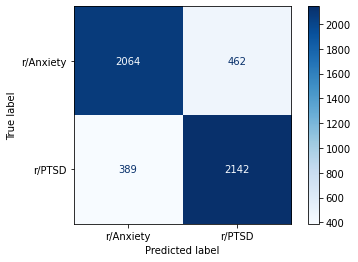

In [430]:
# Generate predictions.
preds = gs_pipe6.predict(X_test)

# Generate confusion matrix.
# Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

confusion_matrix(y_test, # True values.
                 preds)  # Predicted values.

# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

# Plot Confusion matrix
plot_confusion_matrix(gs_pipe6, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['r/Anxiety', 'r/PTSD']);                 

## Receiver Operating Characteristic (ROC) Curve

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


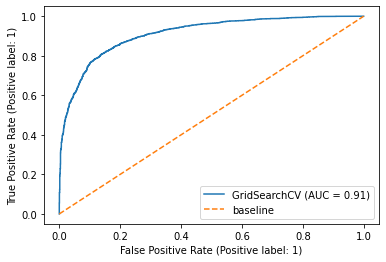

In [431]:
plot_roc_curve(gs_pipe3, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [432]:
roc_auc_score(y_test, gs_pipe3.predict_proba(X_test)[:,1])

0.911426732898441